# Example usage: jet core algorithms and plotting onto a globe
Entire notebook takes ~10 minutes to run on Intel i7-10750

## Index
[Koch et al. 2006](#Koch-et-al.-2006)  
[Schiemann et al. 2009](#Schiemann-et-al.-2009)  
[Manney et al. 2011](#Manney-et-al.-2011)  
[Pena-Ortiz et al. 2013](#Pena-Ortiz-et-al.-2013)  
[Kuang et al. 2014](#Kuang-et-al.-2014)  
[Make visualisations](#Make-visualisations)  
[Extra](#Extra)

preprint describing the package: https://egusphere.copernicus.org/preprints/2023/egusphere-2023-661/

In [1]:
## For calculation of jet core algorithms
import numpy as np
import xarray as xr
import jsmetrics
print("xarray version:", xr.__version__) ## tested on 0.1.3
print("jsmetrics version:", jsmetrics.__version__) ## tested on 2023.3.0


## For plotting
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns 
import cartopy.crs as ccrs


xarray version: 2023.3.0
jsmetrics version: 0.1.6-alpha


## **Data**:

In [2]:
ua = xr.open_dataset('data/era5_u_wind_JF21.nc')
va = xr.open_dataset('data/era5_v_wind_JF21.nc')

In [3]:
uava = xr.merge([ua, va])

In [4]:
uava

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 91, level: 6, time: 59)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 86.0 ... 3.0 2.0 1.0 0.0
  * level      (level) int32 100 250 300 500 700 850
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-02-28
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

## rename data
Important so the data is in correct standardised format for jsmetrics.
Note: this may be changed in the future to accept broader inputs

In [5]:
## this is necessary because jsmetrics currently only accept standardised names as input
uava = uava.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'u':'ua', 'v':'va'})


In [6]:
uava

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 91, plev: 6, time: 59)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 85.0 ... 4.0 3.0 2.0 1.0 0.0
  * plev     (plev) int32 100 250 300 500 700 850
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-02-28
Data variables:
    ua       (time, plev, lat, lon) float32 ...
    va       (time, plev, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [7]:
## select a small subset to speed up this notebook
uava = uava.sel(time=slice("2021-02-11", "2021-02-19"))

## Run jet core algorithms
Note: here the example data is daily ERA-5 which has been re-formatted to 1 by 1 deg lat/lon

### Koch et al. 2006

In [8]:
%%time
# This takes 0.06 seconds on Intel i7-10750
koch = jsmetrics.jet_core_algorithms.koch_et_al_2006(uava.sel(plev=slice(100, 400)))


CPU times: user 33 ms, sys: 646 µs, total: 33.7 ms
Wall time: 32.8 ms


In [9]:
koch

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 91, time: 9)
Coordinates:
  * lon            (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat            (lat) float32 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
    plev           int32 100
  * time           (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19
Data variables:
    jet_events_ws  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [10]:
koch_month_climatology = koch.groupby("time.month").mean("time")

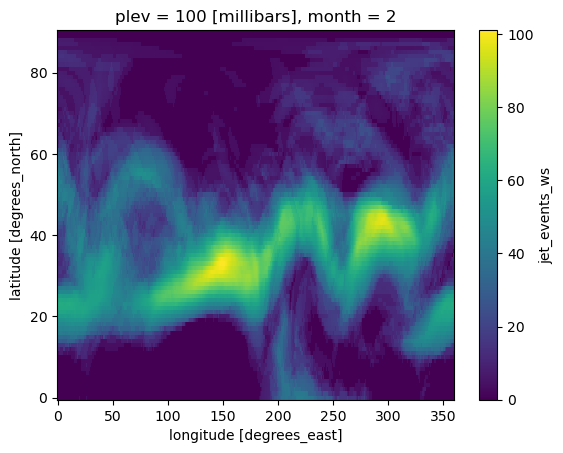

In [11]:
koch_month_climatology['jet_events_ws'].plot()

### Schiemann et al. 2009

In [12]:
%%time
# This takes 1.5 minutes on Intel i7-10750
schiemann = jsmetrics.jet_core_algorithms.schiemann_et_al_2009(uava.sel(plev=slice(100, 500)))


CPU times: user 1min 30s, sys: 611 ms, total: 1min 30s
Wall time: 1min 30s


In [13]:
schiemann

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 91, plev: 4, time: 9)
Coordinates:
  * lon            (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat            (lat) float32 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * plev           (plev) int32 100 250 300 500
  * time           (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19
Data variables:
    ua             (time, plev, lat, lon) float32 -6.241 -7.939 ... 0.0004864
    va             (time, plev, lat, lon) float32 0.2133 1.344 ... 0.001328
    ws             (time, plev, lat, lon) float32 6.245 8.051 ... 0.001414
    jet_occurence  (time, plev, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

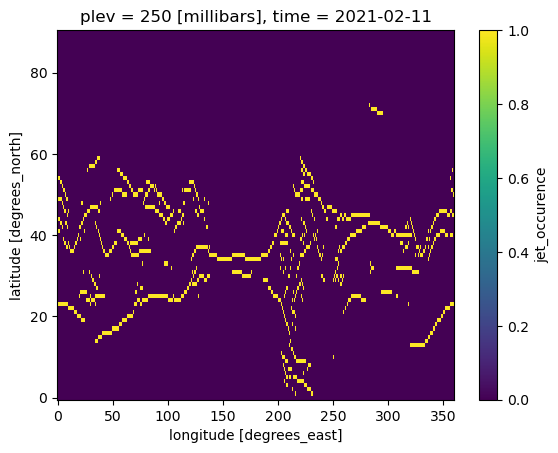

In [14]:
schiemann['jet_occurence'].isel(time=0, plev=1).plot()

### Manney et al. 2011

In [137]:
%%time
# This takes 25 seconds on Intel i7-10750
manney = jsmetrics.jet_core_algorithms.manney_et_al_2011(uava.sel(plev=slice(100, 500)), jet_core_plev_limit=(100, 400))


CPU times: user 32.3 s, sys: 35.5 ms, total: 32.4 s
Wall time: 32.4 s


In [138]:
manney

<xarray.Dataset>
Dimensions:                  (lon: 360, lat: 91, plev: 4, time: 9)
Coordinates:
  * lon                      (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                      (lat) float32 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * plev                     (plev) int32 100 250 300 500
  * time                     (time) datetime64[ns] 2021-02-11 ... 2021-02-19
Data variables:
    ua                       (time, plev, lat, lon) float32 -6.241 ... 0.0004864
    va                       (time, plev, lat, lon) float32 0.2133 ... 0.001328
    ws                       (time, plev, lat, lon) float32 6.245 ... 0.001414
    jet_region_mask          (time, plev, lat, lon) int32 0 0 0 0 0 ... 0 0 0 0
    jet_region_contour_mask  (time, plev, lat, lon) int32 0 0 0 0 0 ... 0 0 0 0
    jet_core_mask            (time, plev, lat, lon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### Pena-Ortiz et al. 2013

In [17]:
%%time
# This takes 0.5 minutes on Intel i7-10750
pena = jsmetrics.jet_core_algorithms.penaortiz_et_al_2013(uava.sel(plev=slice(100, 400)))


CPU times: user 38.2 s, sys: 96 ms, total: 38.3 s
Wall time: 38.3 s


In [18]:
pena

<xarray.Dataset>
Dimensions:                         (lon: 360, lat: 91, plev: 3, time: 9,
                                     monthyear: 1)
Coordinates:
  * lon                             (lon) float32 0.0 1.0 2.0 ... 358.0 359.0
  * lat                             (lat) float32 0.0 1.0 2.0 ... 88.0 89.0 90.0
  * plev                            (plev) int32 100 250 300
  * time                            (time) datetime64[ns] 2021-02-11 ... 2021...
  * monthyear                       (monthyear) datetime64[ns] 2021-02-01
Data variables:
    ua                              (time, plev, lat, lon) float32 -6.241 ......
    va                              (time, plev, lat, lon) float32 0.2133 ......
    ws                              (time, plev, lat, lon) float32 6.245 ... ...
    local_wind_maxima               (time, plev, lat, lon) float64 0.0 ... 0.0
    local_wind_maxima_by_monthyear  (monthyear, plev, lat, lon) float64 0.0 ....
    polar_front_jet                 (monthyear, plev, lat, lon) float64 nan ....
    subtropical_jet                 (monthyear, plev, lat, lon) float64 nan ....
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### Kuang et al. 2014

In [19]:
%%time
# This takes 4 minutes on Intel i7-10750
kuang = jsmetrics.jet_core_algorithms.kuang_et_al_2014(uava.sel(plev=slice(200, 250)))

CPU times: user 4min 5s, sys: 573 ms, total: 4min 6s
Wall time: 4min 6s


In [20]:
kuang

<xarray.Dataset>
Dimensions:                     (lon: 360, lat: 91, time: 9)
Coordinates:
  * lon                         (lon) float32 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * lat                         (lat) float32 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
    plev                        int32 250
  * time                        (time) datetime64[ns] 2021-02-11 ... 2021-02-19
Data variables:
    ws                          (time, lat, lon) float32 5.551 ... 0.002714
    jet_ocurrence1_jet_centre2  (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0

In [21]:
%%time
# This takes 0.02 seconds on Intel i7-10750
# get resultant wind speed from U and V components
ws = jsmetrics.utils.windspeed_utils.get_resultant_wind(uava["ua"], uava["va"])

CPU times: user 16.9 ms, sys: 4.01 ms, total: 20.9 ms
Wall time: 20.5 ms


In [22]:
ws

<xarray.DataArray (time: 9, plev: 6, lat: 91, lon: 360)>
array([[[[1.81000773e-03, 1.81000773e-03, 1.81000773e-03, ...,
          1.81000773e-03, 1.81000773e-03, 1.81000773e-03],
         [1.49712505e+01, 1.49702768e+01, 1.49648170e+01, ...,
          1.49749146e+01, 1.49751215e+01, 1.49739838e+01],
         [1.79184017e+01, 1.79097786e+01, 1.79029751e+01, ...,
          1.79206142e+01, 1.79239120e+01, 1.79202881e+01],
         ...,
         [5.62411547e+00, 6.43523359e+00, 7.28243876e+00, ...,
          3.77414274e+00, 4.35775757e+00, 4.29692650e+00],
         [5.00210762e+00, 5.97678280e+00, 7.43222809e+00, ...,
          2.71768713e+00, 3.39839292e+00, 3.60970712e+00],
         [6.24481344e+00, 8.05140400e+00, 9.83108616e+00, ...,
          2.18496323e+00, 1.86842215e+00, 3.98806167e+00]],

        [[1.41425629e-03, 1.41425629e-03, 1.41425629e-03, ...,
          1.41425629e-03, 1.41425629e-03, 1.41425629e-03],
         [1.92980366e+01, 1.92998734e+01, 1.93008270e+01, ...,
          1.92826710e+01, 1.92907467e+01, 1.92967358e+01],
         [2.54078178e+01, 2.53849792e+01, 2.53587666e+01, ...,
          2.54562988e+01, 2.54453201e+01, 2.54273853e+01],
...
          1.15720711e+01, 1.07396402e+01, 1.03353443e+01],
         [8.55271435e+00, 7.95085621e+00, 7.13749409e+00, ...,
          1.16030102e+01, 1.01394310e+01, 9.60041618e+00],
         [6.52856684e+00, 6.40404701e+00, 6.51279736e+00, ...,
          1.01265240e+01, 9.12355995e+00, 7.19407797e+00]],

        [[1.81000773e-03, 1.81000773e-03, 1.81000773e-03, ...,
          1.81000773e-03, 1.81000773e-03, 1.81000773e-03],
         [1.00729532e+01, 1.00331469e+01, 9.99402332e+00, ...,
          1.01846895e+01, 1.01503172e+01, 1.01128578e+01],
         [1.12527189e+01, 1.12136364e+01, 1.11771994e+01, ...,
          1.13757343e+01, 1.13310213e+01, 1.12909403e+01],
         ...,
         [3.50647116e+00, 2.66889000e+00, 3.80496192e+00, ...,
          3.77546406e+00, 3.11113477e+00, 2.70777321e+00],
         [3.67503476e+00, 3.63161087e+00, 3.23333359e+00, ...,
          2.55096579e+00, 2.69510651e+00, 3.03861117e+00],
         [4.77490234e+00, 4.02672815e+00, 3.71727109e+00, ...,
          3.53575754e+00, 2.98312473e+00, 4.20243168e+00]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 90.0 89.0 88.0 87.0 86.0 85.0 ... 4.0 3.0 2.0 1.0 0.0
  * plev     (plev) int32 100 250 300 500 700 850
  * time     (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19

# Jet core algorithm

In [23]:
%%time
# This takes 2 minutes on Intel i7-10750
jca = jsmetrics.jet_core_algorithms.jet_core_identification_algorithm(uava.sel(plev=slice(100, 400)))

CPU times: user 1min 49s, sys: 244 ms, total: 1min 49s
Wall time: 1min 49s


In [24]:
jca

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 91, plev: 3, time: 9)
Coordinates:
  * lon          (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat          (lat) float32 0.0 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0 90.0
  * plev         (plev) int32 100 250 300
  * time         (time) datetime64[ns] 2021-02-11 2021-02-12 ... 2021-02-19
Data variables:
    ua           (time, plev, lat, lon) float32 -6.241 -7.939 ... 0.0004864
    va           (time, plev, lat, lon) float32 0.2133 1.344 ... 0.001328
    jet_core_id  (time, plev, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 11:51:26 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

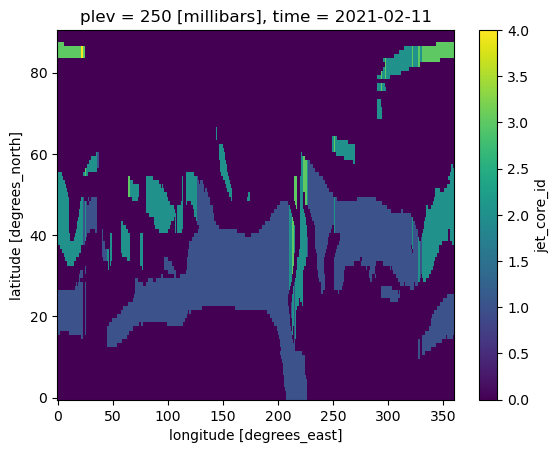

In [25]:
jca['jet_core_id'].isel(time=0, plev=1).plot()

# Make visualisations

## Plot 5 jet core algorithms

In [26]:
DATE_TO_PLOT = "2021-02-15 00:00"

In [27]:
uava_sub = uava.sel(time=slice(DATE_TO_PLOT, DATE_TO_PLOT))

In [28]:
uava_sub["plev"] = (("plev"), uava_sub.plev.data, {"units":"hPa"})

ws_sub = jsmetrics.utils.windspeed_utils.get_resultant_wind(uava_sub["ua"], uava_sub["va"])

In [142]:
## Define function for plotting 5 jet cores at once
def plot_5_jet_cores_algorithms(koch, schiemann, manney_core, manney_region, pena, kuang,  cbar_labels, projection=ccrs.Orthographic(0, 90),\
                                orientation='horizontal', shrink=.7, vmax=None, **plot_kwargs):
    fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(20,14), subplot_kw={'projection': projection, 'facecolor':"gray"})

    p = koch.plot.contourf(ax=axes[0][1], transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                      'label': cbar_labels[0]}, **plot_kwargs)
    p.colorbar.set_label(cbar_labels[0], size=15)
    p.colorbar.set_ticklabels(np.arange(0, 121, 20), size=15)
    gl = axes[0][1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p.axes.coastlines()
    axes[0][1].set_title('')
    
    p2 = schiemann.plot.contourf(ax=axes[0][2], levels=[0,0.5,1], transform=ccrs.PlateCarree(),
                                 cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                      'label': cbar_labels[1], "ticks":[0.25, 0.75]}, **plot_kwargs)
    p2.colorbar.set_label(cbar_labels[1], size=16)

    p2.colorbar.set_ticklabels(["no jet", "jet maxima"], size=15)
    gl2 = axes[0][2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p2.axes.coastlines()
    axes[0][2].set_title('')
    
    manney = ((manney_core/ manney_region) + 0.5).fillna(0.0)
    p3 = manney.plot.contourf(ax=axes[1][0], levels=[0,0.25,1, 1.5],transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                      'label': cbar_labels[2], "ticks":[0.125, 0.625, 1.275]}, cmap=matplotlib.colormaps["YlGnBu"], **plot_kwargs)
    p3.colorbar.set_label(cbar_labels[2], size=16)
    p3.colorbar.set_ticklabels(["no jet", "jet region", "jet core"], size=15)
    gl3 = axes[1][0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p3.axes.coastlines()
    axes[1][0].set_title('')
    if pena.max() == 1:
        p4 = pena.plot.contourf(ax=axes[1][1], levels=[0,0.5,1], transform=ccrs.PlateCarree(),
                                cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                          'label': cbar_labels[3], 'ticks':[0.25,0.75]}, **plot_kwargs)
        p4.colorbar.set_label(cbar_labels[3], size=16)
        p4.colorbar.set_ticklabels(["no jet", "local wind maxima"], size=15)
    else:
        p4 = pena.plot.contourf(ax=axes[1][1], levels=[0,0.5,1], transform=ccrs.PlateCarree(),
                                cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                          'label': cbar_labels[3], "ticks":[0.25, 0.75]}, vmax=vmax, **plot_kwargs)
        p4.colorbar.set_label(cbar_labels[3], size=16)
        p4.colorbar.set_ticklabels(["no jet", "local wind maxima"], size=15)
    gl4 = axes[1][1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p4.axes.coastlines()
    axes[1][1].set_title('')

    if kuang.max() == 1:
        p5 = kuang.plot.contourf(ax=axes[1][2], levels=[0, 0.5, 1, 2], transform=ccrs.PlateCarree(),
                                 cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink, 
                                                                                          'label': cbar_labels[4], "ticks":[0.25, 0.75, 1.5]}, **plot_kwargs)
        p5.colorbar.set_label(cbar_labels[4], size=16)
        p5.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=15)
        
    else:
        p5 = kuang.plot.contourf(ax=axes[1][2], levels=[0, 0.5, 1, 2], transform=ccrs.PlateCarree(),
                                 cmap=matplotlib.colormaps["YlGnBu"], cbar_kwargs={'orientation':orientation, 'shrink':shrink,
                                                                                          'label': cbar_labels[4], "ticks":[0.25, 0.75, 1.5]}, **plot_kwargs)
        p5.colorbar.set_label(cbar_labels[4], size=16)
        p5.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=15)

    gl5 = axes[1][2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    p5.axes.coastlines()
    axes[1][2].set_title('')
    return fig, axes

In [140]:
cbar_labels = ['Weighted average wind-speed (400 - 100 hPa)', '500-100 hPa', 'Jet Core (400 - 100 hPa)','400-100 hPa',\
               "250 hPa"]

CPU times: user 6.07 s, sys: 2.32 s, total: 8.39 s
Wall time: 5.52 s


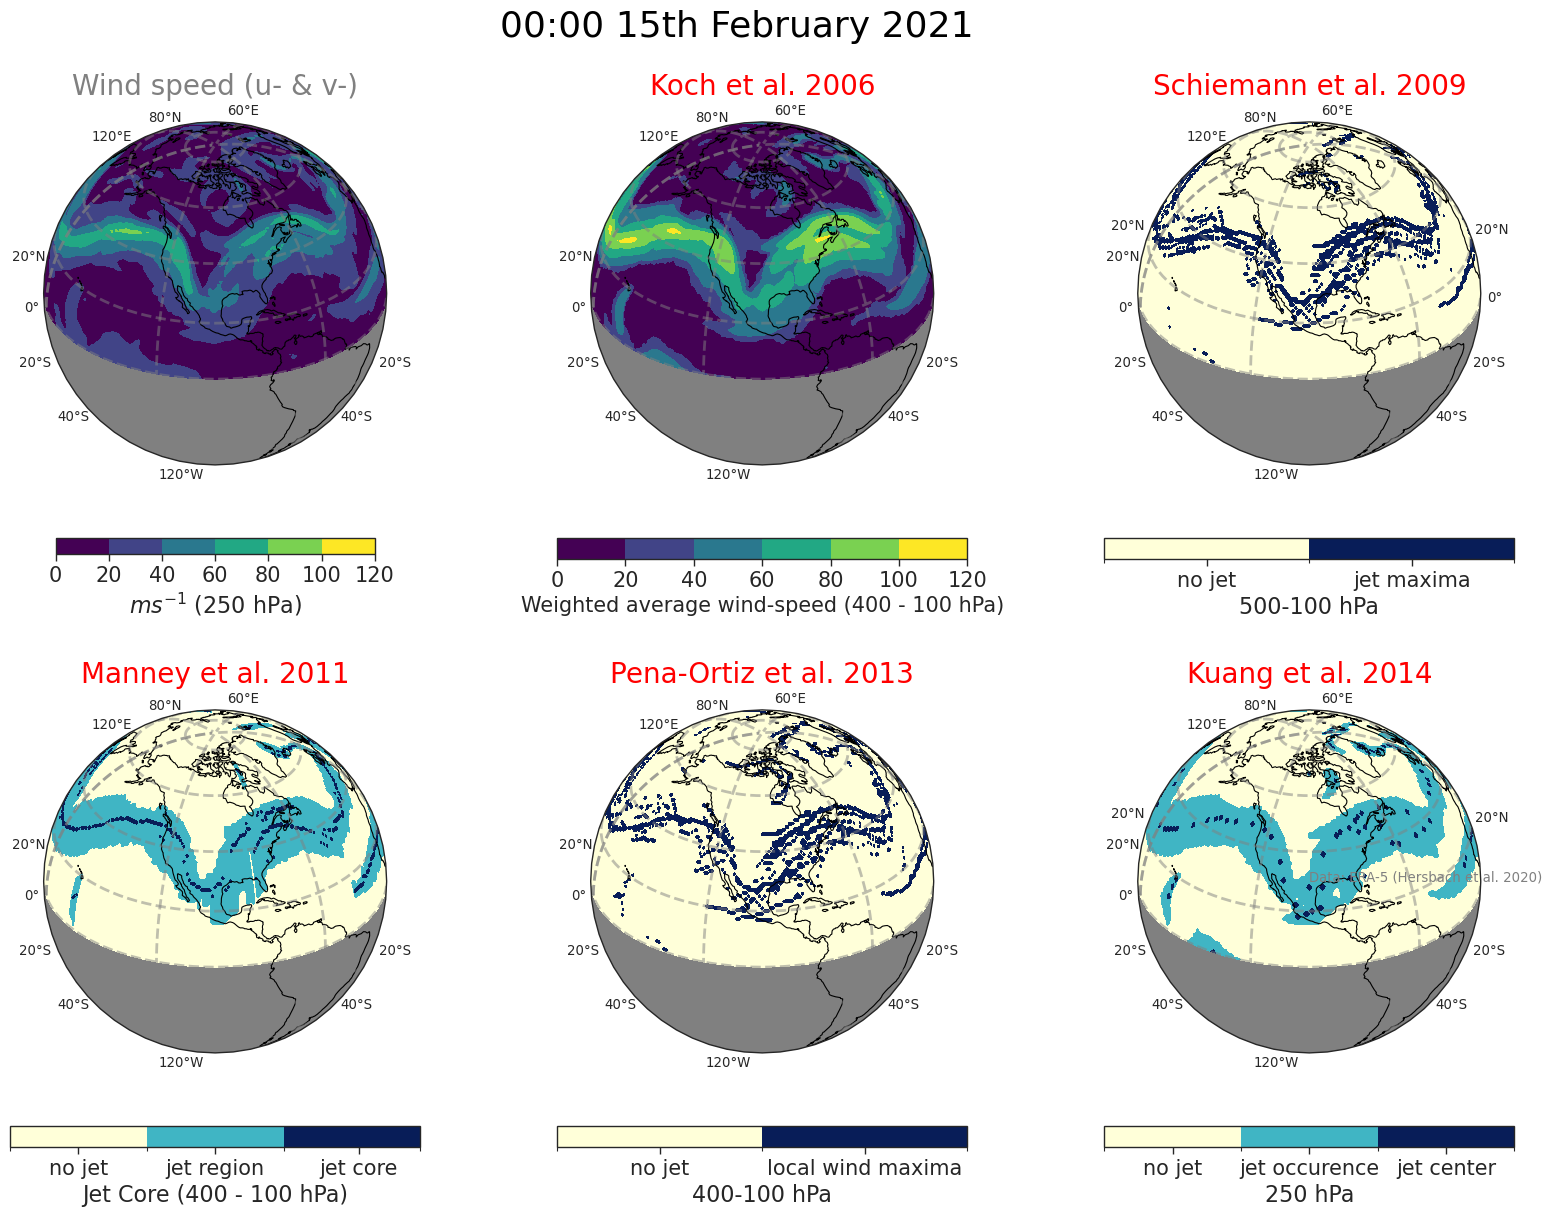

In [143]:
%%time
# This takes ~3 seconds on Intel i7-10750
sns.set_context('paper')
sns.set_style('white')


fig, axes = plot_5_jet_cores_algorithms(
                            koch.sel(time=DATE_TO_PLOT)['jet_events_ws'],
                            schiemann.sel(time=DATE_TO_PLOT)['jet_occurence'].max('plev'),
                            manney.sel(time=DATE_TO_PLOT)['jet_core_mask'].max('plev'),\
                            manney.sel(time=DATE_TO_PLOT)['jet_region_mask'].max('plev'),\
                            pena.sel(time=DATE_TO_PLOT)['local_wind_maxima'].max('plev'),\
                            kuang.sel(time=DATE_TO_PLOT)['jet_ocurrence1_jet_centre2'],\
                            projection= ccrs.Orthographic(central_latitude=30, central_longitude=-100),
                                        cbar_labels=cbar_labels, shrink=.9)
# axes[0][1].set_extent([-160, -30, 5, 75])
axes[0][1].set_title('Koch et al. 2006', color='red', size=20)
# axes[0][2].set_extent([-160, -30, 5, 75])
axes[0][2].set_title('Schiemann et al. 2009', color='red', size=20)
# axes[1][0].set_extent([-160, -30, 5, 75])
axes[1][0].set_title('Manney et al. 2011', color='red', size=20)
# axes[1][1].set_extent([-160, -30, 5, 75])
axes[1][1].set_title('Pena-Ortiz et al. 2013', color='red', size=20)
# axes[1][2].set_extent([-160, -30, 5, 75])
axes[1][2].set_title('Kuang et al. 2014', color='red', size=20)

p = ws_sub.isel(plev=2, time=0).plot.contourf(ax=axes[0][0], transform=ccrs.PlateCarree(), vmax=120, cbar_kwargs={'orientation':'horizontal', 'shrink':.7})
p.colorbar.set_label(r"${ms^{-1}}$ (250 hPa)", size=16)
p.colorbar.set_ticklabels(np.arange(0, 121, 20), size=15)
gl = axes[0][0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# axes[0][0].set_extent([-160, -30, 5, 75])
axes[0][0].set_title('Wind speed (u- & v-)', color='grey', size=20)
p.axes.coastlines()
 
# fig.subplots_adjust(wspace=-.05)
plt.suptitle('00:00 15th February 2021', x=0.5, y=0.96, size=26, color='k')
plt.text(s='Data: ERA-5 (Hersbach et al. 2020)', x=70, y=-30, color='grey')


## Extra
Look at impact of temporal aggregation on position of jet cores

In [29]:
projection = ccrs.Orthographic(central_latitude=30, central_longitude=-100)

In [30]:
## to run Kuang et al. 2014 again if necessary
# kuang = jsmetrics.jet_core_algorithms.kuang_et_al_2014(uava.sel(plev=slice(200, 250)))

CPU times: user 4min, sys: 328 ms, total: 4min
Wall time: 4min


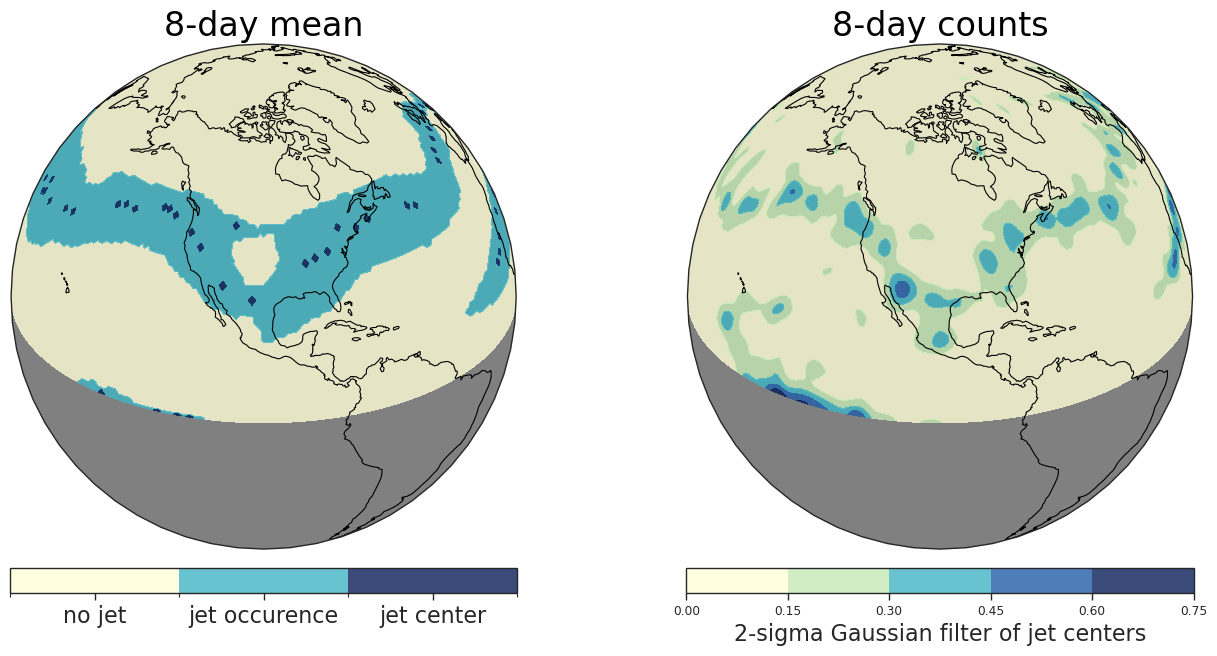

In [31]:
%%time
## Takes ~3.5 minutes on Intel i7-10750
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(16,8), subplot_kw={'projection': projection, 'facecolor':"gray"})
sns.set_style('white')

alt_time_sels_to_use = (slice("2021-02-11 12:00", "2021-02-19 12:00"),\
                        slice("2021-02-11 12:00", "2021-02-19 12:00"))
alt_labels_to_use = ("8-day mean", "8-day counts")
counter = 0
for ax in axes:
    time_sel = alt_time_sels_to_use[counter]
    data = uava.sel(plev=250, time=time_sel)
    if "mean" in alt_labels_to_use[counter]:
        data = data.mean("time")
        try:
            data['time'] = (("time"), ["2021-02-15 00:00"])
        except ValueError:
            pass
        
        kuang = jsmetrics.metrics.jet_core_algorithms.kuang_et_al_2014(data.isel(time=0))

    else:
        kuang = jsmetrics.metrics.jet_core_algorithms.kuang_et_al_2014(data)
    if kuang['time'].size == 1:
        temp_plot = kuang["jet_ocurrence1_jet_centre2"].plot.contourf(ax=ax,alpha=.8, levels=[0, 0.5, 1, 2], cmap='YlGnBu', transform=ccrs.PlateCarree(),  
                                                         cbar_kwargs={'orientation':'horizontal', 'shrink':.9,
                                                                    "pad":0.03, "ticks":[0.25, 0.75, 1.5]})
        temp_plot.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=16)
        temp_plot.colorbar.set_label("", size=16)

    else:
        jet_center_counts = kuang["jet_ocurrence1_jet_centre2"].where(lambda x: x==2)
        jet_centers_gaussian = ndimage.gaussian_filter(jet_center_counts.sum('time'), sigma=2.0, order=0)
        jet_center_counts['jet_centers_gaussian'] = (('lat', 'lon'), jet_centers_gaussian)
        temp_plot = jet_center_counts['jet_centers_gaussian'].plot.contourf(ax=ax,alpha=.8, cmap='YlGnBu', transform=ccrs.PlateCarree(),  
                                                 cbar_kwargs={'orientation':'horizontal', 'shrink':.9, "pad":0.03})
        temp_plot.colorbar.set_label("2-sigma Gaussian filter of jet centers", size=16)
        
    ax.coastlines()
    ax.set_title(alt_labels_to_use[counter], size=24, color='Black')
    counter += 1

CPU times: user 1min 49s, sys: 172 ms, total: 1min 50s
Wall time: 1min 49s


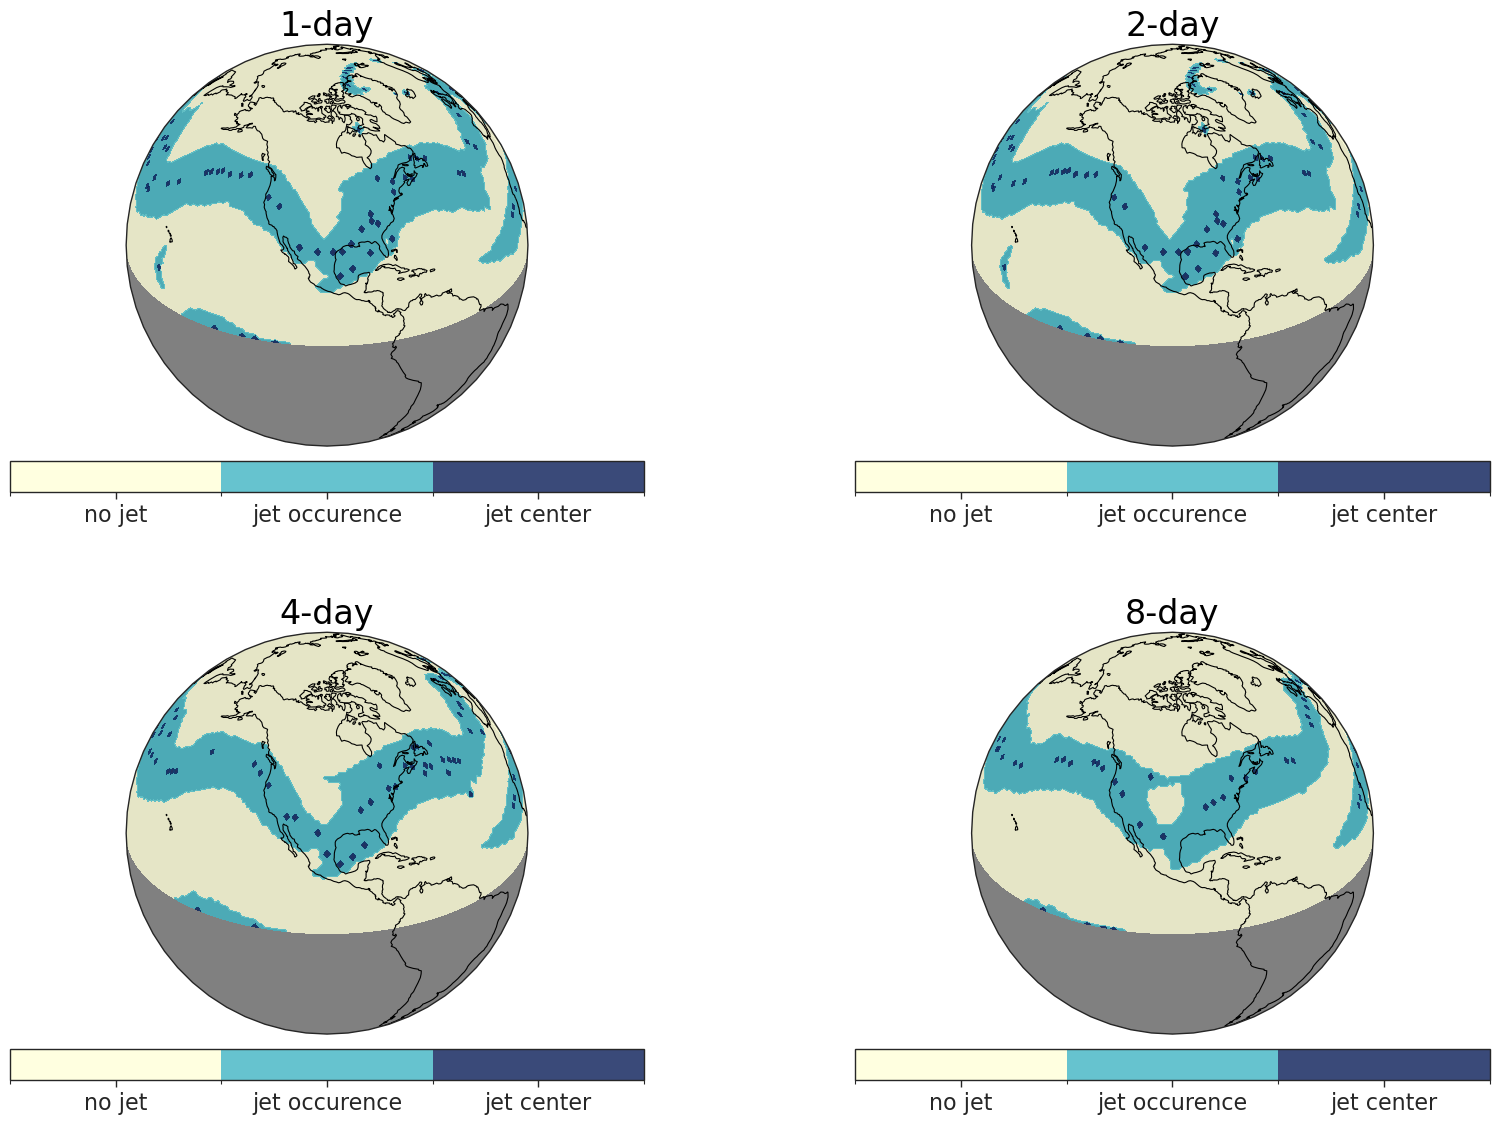

In [32]:
%%time
## Takes ~1.5 minutes on Intel i7-10750
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(20,14), subplot_kw={'projection': projection, 'facecolor':"gray"})
sns.set_style('white')
time_sels_to_use = (slice("2021-02-15 00:00", "2021-02-16 00:00"),\
                    slice("2021-02-14 12:00", "2021-02-16 12:00"),\
                    slice("2021-02-13 12:00", "2021-02-17 12:00"),\
                    slice("2021-02-11 12:00", "2021-02-19 12:00"))
labels_to_use = ("1-day", "2-day", "4-day", "8-day")
assert axes.size == len(time_sels_to_use)
counter = 0
for ax_row in axes:
    for ax in ax_row:
        time_sel = time_sels_to_use[counter]
        data = uava.sel(plev=250, time=time_sel)
        if data["time"].size > 1:
            data = data.mean("time")
        data['time'] = (("time"), ["2021-02-15 00:00"])
        kuang = jsmetrics.metrics.jet_core_algorithms.kuang_et_al_2014(data.isel(time=0))
        temp_plot = kuang["jet_ocurrence1_jet_centre2"].plot.contourf(ax=ax,alpha=.8, levels=[0, 0.5, 1, 2], cmap='YlGnBu', transform=ccrs.PlateCarree(),  
                                                             cbar_kwargs={'orientation':'horizontal', 'shrink':.9,
                                                                        "pad":0.03, "ticks":[0.25, 0.75, 1.5]})
        temp_plot.colorbar.set_ticklabels(["no jet","jet occurence","jet center"], size=16)
        temp_plot.colorbar.set_label("")
        ax.coastlines()
        ax.set_title(labels_to_use[counter], size=24, color='Black')
        counter += 1